In [1]:
%pip install requests --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install wordcloud --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install nltk --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install requests_cache --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import requests
import json
import pandas as pd
import requests_cache
import requests
import json
from datetime import datetime
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.animation as animation

In [23]:
# Set the API key and parameters
# api_key = "ABCINSERTYOURSHERE"

# Article Search

In [7]:
query = 'Formula One'

# Create a cache for the requests using requests_cache
requests_cache.install_cache('nyt_cache')

range_num = 200
articles = []

with requests_cache.enabled():
    for page in range(range_num):
        url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&api-key={api_key}&page={page}'
        response = requests.get(url)

        if response.from_cache:
            print(f'Using cached response for page {page}')
        else:
            print(f'Making API request for page {page}')
            time.sleep(10) # add a delay of 10 seconds between requests

        data = json.loads(response.text)
        articles += data['response']['docs']
        

article_data = []

for article in articles:
    article_dict = {}
    article_dict['date'] = article['pub_date']
    pub_date = datetime.strptime(article['pub_date'], '%Y-%m-%dT%H:%M:%S%z')
    article_dict['year'] = pub_date.year
    article_dict['month'] = pub_date.month
    article_dict['headline'] = article['headline']['main']
    article_dict['abstract'] = article['abstract']
    article_dict['url'] = article['web_url']
    article_data.append(article_dict)

df = pd.DataFrame(article_data)
df.head(1)

Using cached response for page 0
Using cached response for page 1
Using cached response for page 2
Using cached response for page 3
Using cached response for page 4
Using cached response for page 5
Using cached response for page 6
Using cached response for page 7
Using cached response for page 8
Using cached response for page 9
Using cached response for page 10
Using cached response for page 11
Using cached response for page 12
Using cached response for page 13
Using cached response for page 14
Using cached response for page 15
Using cached response for page 16
Using cached response for page 17
Using cached response for page 18
Using cached response for page 19
Using cached response for page 20
Using cached response for page 21
Using cached response for page 22
Using cached response for page 23
Using cached response for page 24
Using cached response for page 25
Using cached response for page 26
Using cached response for page 27
Using cached response for page 28
Using cached response fo

,date,year,month,headline,abstract,url
0,2023-02-03T14:24:37+0000,2023,2,Ford Partners With Red Bull in Return to Formu...,The automaker and the drinks manufacturer are ...,https://www.nytimes.com/2023/02/03/sports/auto...


# Analysis

In [8]:
df_analysis = df.copy()

In [9]:
df_analysis['year'].value_counts().head(5)

2009    132
2008    116
2006    109
2007    104
2011     94
Name: year, dtype: int64

In [10]:
df_analysis.count()

date        2000
year        2000
month       2000
headline    2000
abstract    2000
url         2000
dtype: int64

In [11]:
df_analysis = df_analysis.drop_duplicates('url')

In [12]:
pd.set_option('display.max_colwidth', None)
# df_analysis[df_analysis['year'] == 2009]

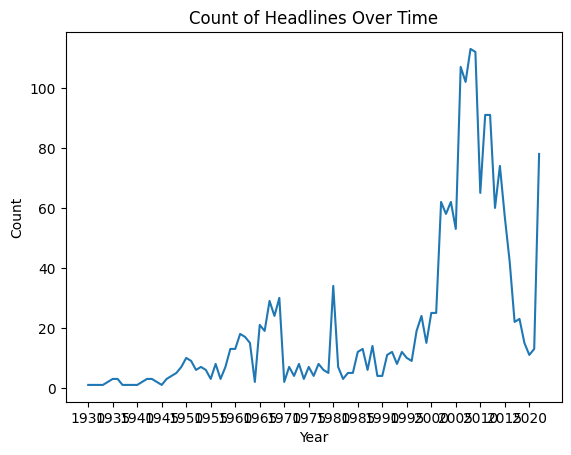

In [13]:
import matplotlib.pyplot as plt

# Filter out any rows with a year value of 2023
df_plt_2022 = df_analysis[df_analysis['year'] != 2023]

# Group the data by year and count the number of rows in each year
counts = df_plt_2022.groupby('year').count()

# Create a line plot of the counts over time
plt.plot(counts.index, counts['date'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Headlines Over Time')

# Set the x-axis tick marks to be every 5 years
plt.xticks(range(int(counts.index.min()), int(counts.index.max()) + 1, 5))

plt.show()

In [14]:
counts_df_out = counts.reset_index()[['year', 'headline']]

In [15]:
# df_analysis.to_csv("2023_03_06_F1_API_calls.csv")

In [16]:
df_join = pd.read_csv('season_results.csv').reset_index().rename(columns={'Year': 'year'})
del df_join['index']
df_join.head(1)

,year,Value,Metric
0,2000,19.0,Driver's Championship Point Difference


In [17]:
counts_df_out = counts_df_out.rename(columns={'headline': 'Value'})
counts_df_out['Metric'] = 'Count of NYT Headlines Mentioning Formula 1'
counts_df_out.head(1)

,year,Value,Metric
0,1930,1,Count of NYT Headlines Mentioning Formula 1


In [18]:
df_union = pd.concat([df_join, counts_df_out])
df_union['Metric'].value_counts()

Count of NYT Headlines Mentioning Formula 1    88
Driver's Championship Point Difference         23
Constructor's Championship Point Difference    23
Name: Metric, dtype: int64

In [19]:
df_union.to_csv("count_nyt_arts_over.csv")

# Animated Word Cloud Over Time

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacksonburton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
MovieWriter imagemagick unavailable; using Pillow instead.


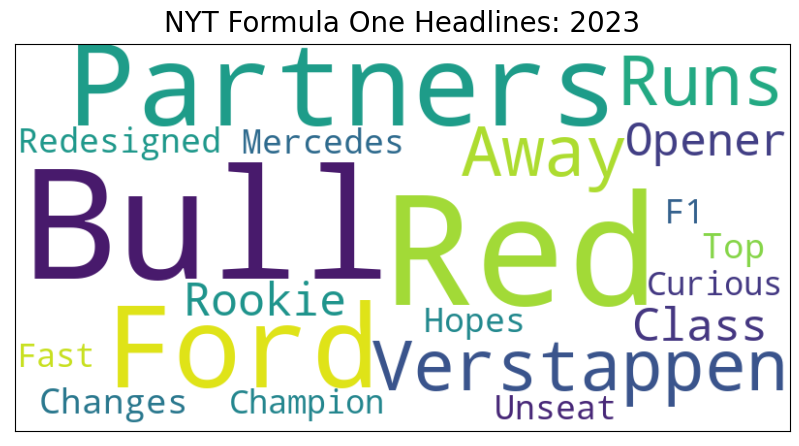

In [20]:
# Load the data containing the headlines and the year they appeared in
data = df.copy()

# Filter the data to include only years 2002-2022
data = data[(data['year'] >= 2008) & (data['year'] <= 2023)]

# Some baby related headlines slipping through "formula"
data = data[~data['headline'].str.contains('baby', case=False)]
data = data[~data['headline'].str.contains('infant', case=False)]
data = data[~data['headline'].str.contains('feeding', case=False)]

# Create a figure to display the animation
fig = plt.figure(figsize=(10, 6))

# Create a list of unique years in the data
years = sorted(data['year'].unique())

# Define a list of custom keywords to include in the word cloud
custom_keywords = ['formula', 'one', 'team', 'driver', 'new', 'old', 
                   'u','race', 'way', 'uses', 'look', 'many',
                  'season', 'Monday', 'Makes', 'car', 'knows','run','.','make',
                  'racing', 'motorsports', 'everyone', 'feed','return','returns','road','drivers','breast']

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
generic_stopwords = set(stopwords.words('english'))

# Combine the custom keywords and generic stopwords into a single set
stopwords = set(custom_keywords) | generic_stopwords

def update(frame):
    # Get the current year
    year = years[frame]

    # Filter the data to get the headlines for the current year
    headlines = data[data['year'] == year]['headline'].tolist()

    # Join the headlines into a single string
    text = ' '.join(headlines)

    # Generate the word cloud for the current year
    wc = WordCloud(width=800, height=400, background_color='white', max_words=20, stopwords=stopwords)
    wc.generate_from_text(text)

    # Update the current frame with the new word cloud
    images[0].set_data(wc.to_array())

    # Set the title for the current frame
    plt.title("NYT Formula One Headlines: " + str(year), fontsize=20, y=1.01)

    return images

# Generate the word cloud for the first year
headlines = data[data['year'] == years[0]]['headline'].tolist()
words = [word for headline in headlines for word in headline.split()]
wc = WordCloud(width=800, height=400, background_color='white', max_words=50)
wc.generate_from_text(' '.join(words))

# Create an AxesImage object for the word cloud
image = plt.imshow(wc, animated=True, interpolation='bilinear', aspect='equal')

# Remove the x and y axis tickers
plt.xticks([])
plt.yticks([])

images = [image]

# Use matplotlib.animation to create a gif of the word clouds
ani = animation.FuncAnimation(fig, update, frames=len(years), interval=5000, repeat_delay=1000, blit=True)

ani.save('wordclouds.gif', writer='imagemagick', fps=0.25)

# Display the animation
plt.show()

In [21]:
# df[df['headline'].str.contains('bribery', case = False)].head(1)

In [22]:
# # Create a list of years to include in the filter
# years = [2008, 2009, 2010]

# # Filter the dataframe for rows where the year is in the list of years
# filtered_df = df[df['year'].isin(years)]
# filtered_df.head(1)